In [1]:

def displayMaze(maze, displayState):
    # create a new figure
    plt.figure(figsize=(10, 5))

    # display the maze
    plt.imshow(maze, cmap=plt.cm.binary, interpolation='nearest')
    plt.xticks([]), plt.yticks([])
    if displayState:
        plt.show()


def createMP4(name, imgDirPath):
    # find the number of images in the folder
    numImages = len(os.listdir(imgDirPath))
    
    with imageio.get_writer(name + '.mp4', mode='I') as writer:
        # for each screenshot
        for i in range(numImages - 1):
            # read the screenshot
            image = imageio.imread(imgDirPath + "/" + str(i) + ".png")
            # add the screenshot to the video
            writer.append_data(image)
            # remove the screenshot
            os.remove(imgDirPath + "/" + str(i) + ".png")
    
    # speed up the video by a factor of 3x speed up
    os.system("ffmpeg -i " + name + ".mp4 -filter:v \"setpts=0.333*PTS\" " + name + "SpedUp.mp4 -y")
    # remove the original video
    os.remove(name + ".mp4")
    


Generating a maze with a height of 25 and a width of 25
[[1 1 1 ... 1 1 1]
 [1 0 1 ... 0 0 1]
 [1 0 1 ... 1 0 1]
 ...
 [1 0 1 ... 1 0 1]
 [1 0 0 ... 1 0 1]
 [1 1 1 ... 1 1 1]]
The height of the maze is 51 and the width of the maze is 51


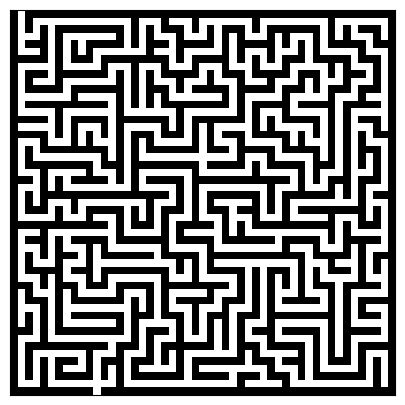

In [2]:
# import backtracking from mazelib package
from mazelib import Maze
from mazelib.generate.BacktrackingGenerator import BacktrackingGenerator

import matplotlib.pyplot as plt
import numpy as np
import random
import math
import time
import sys
import os
import imageio.v2 as imageio



# get the height and width of the maze from the user
while True:
    try:
        height = (int(input("Enter the height of the maze: ")) + 1) // 2
        width = (int(input("Enter the width of the maze: "))  + 1) // 2
        break
    except ValueError:
        print("Please enter a valid integer.")

# print the height and width of the maze 
print("Generating a maze with a height of", height, "and a width of", width)
# create a maze object
newMaze = Maze()
maze_generator = BacktrackingGenerator(width, height)
newMaze = maze_generator.generate()

# print the maze
print(newMaze)

newHeight = newMaze.shape[0]
newWidth = newMaze.shape[1]
print("The height of the maze is", newHeight, "and the width of the maze is", newWidth)

# ensure that the maze is solvable by creating an entrance and exit in a random location on the top and bottom of the maze which must be connected to a 0 in the maze
# create a list of all the 0s in the first and last row of the maze
topRow = []
bottomRow = []
for i in range(newWidth):
    if newMaze[1][i] == 0:
        topRow.append(i)
    if newMaze[newHeight - 2][i] == 0:
        bottomRow.append(i)

# randomly select a 0 from the top and bottom row
top = random.choice(topRow)
bottom = random.choice(bottomRow)

# create an entrance and exit in the maze
newMaze[0][top] = 0
newMaze[newHeight - 1][bottom] = 0

displayMaze(newMaze, True)




In [3]:
def findNeighbors(node, maze):
    # measure the height and width of the maze
    height = maze.shape[0]
    width = maze.shape[1]

    # create a list to store the neighbors of the node
    neighbors = []

    # if the node is not on the top row
    if node[0] != 0:
        # if the node is not a wall
        if maze[node[0] - 1][node[1]] == 0:
            # add the node above to the neighbors list
            neighbors.append((node[0] - 1, node[1]))

    # if the node is not on the bottom row
    if node[0] != height - 1:
        # if the node is not a wall
        if maze[node[0] + 1][node[1]] == 0:
            # add the node below to the neighbors list
            neighbors.append((node[0] + 1, node[1]))

    # if the node is not on the left side
    if node[1] != 0:
        # if the node is not a wall
        if maze[node[0]][node[1] - 1] == 0:
            # add the node to the left to the neighbors list
            neighbors.append((node[0], node[1] - 1))

    # if the node is not on the right side
    if node[1] != width - 1:
        # if the node is not a wall
        if maze[node[0]][node[1] + 1] == 0:
            # add the node to the right to the neighbors list
            neighbors.append((node[0], node[1] + 1))

    # return the neighbors list
    return neighbors

In [4]:

# animate the solving of the maze using BFS by taking a screenshot of each step and saving it to a folder and at the end creating a video of the screenshots to show the solving of the maze
def BFS(maze):
    # measure the height and width of the maze
    height = maze.shape[0]
    width = maze.shape[1]

    # find the entrance and exit of the maze in the first and last row
    for i in range(width):
        if maze[0][i] == 0:
            start = (0, i)
        if maze[height - 1][i] == 0:
            end = (height - 1, i)

    # create a queue to store the nodes to be visited
    queue = []
    # add the start node to the queue
    queue.append(start)

    visited = []
    # create a dictionary to store the parent of each node
    parent = {}
    # set the parent of the start node to None
    parent[start] = None

    # while the queue is not empty
    while queue:
        # remove the first node from the queue
        node = queue.pop(0)

        # if the node is the end node
        if node == end:
            # break out of the loop
            break

        # if the node has not been visited
        if node not in visited:
            # add the node to the visited list
            visited.append(node)

            # find the neighbors of the node
            neighbors = findNeighbors(node, maze)

            # for each neighbor of the node
            for neighbor in neighbors:
                # if the neighbor has not been visited
                if neighbor not in visited:
                    # add the neighbor to the queue
                    queue.append(neighbor)
                    # set the parent of the neighbor to the node
                    parent[neighbor] = node
                
    # create a list to store the path from the start to the end
    path = []
    # add the end node to the path
    path.append(end)

    # while the end node has a parent
    while end in parent:
        # set the end node to its parent
        end = parent[end]
        # add the end node to the path
        path.append(end)
    
    # reverse the path
    path.reverse()

    # create a list to store the path of the maze
    mazePath = []

    # for each node in the path
    for node in path:
        # if the node is not the start node
        if node != start:
            # add the node to the maze path
            mazePath.append(node)

    print(mazePath)
    
    # remove the first element from the maze path
    mazePath.pop(0)

    # for each node in the maze path create a screenshot of the maze with the node and all the nodes before it highlighted and save it to a folder
    for i in range(len(mazePath)):
        # create a copy of the maze
        mazeCopy = maze.copy()
        # for each node in the maze path
        for j in range(i + 1):
            # highlight the node
            mazeCopy[mazePath[j][0]][mazePath[j][1]] = 2
        # for the current node highlight it in a different color to show that it is the current node
        mazeCopy[mazePath[i][0]][mazePath[i][1]] = 3
        # display the maze in the background
        displayMaze(mazeCopy, False)
        # save the maze as a screenshot
        plt.savefig("BFS/" + str(i) + ".png")
        # close the plot
        plt.close()
        
        

    # call the createMP4 function to create a video of the screenshots with the parameters of the name of the file and the folder the screenshots are in
    createMP4("BFS", "BFS")

def DFS(maze):
    # measure the height and width of the maze
    height = maze.shape[0]
    width = maze.shape[1]

    # find the entrance and exit of the maze in the first and last row
    for i in range(width):
        if maze[0][i] == 0:
            start = (0, i)
        if maze[height - 1][i] == 0:
            end = (height - 1, i)

    # create a stack to store the nodes to be visited
    stack = []
    # add the start node to the stack
    stack.append(start)

    visited = []
    # create a dictionary to store the parent of each node
    parent = {}
    # set the parent of the start node to None
    parent[start] = None

    # while the stack is not empty
    while stack:
        # remove the last node from the stack
        node = stack.pop()

        # if the node is the end node
        if node == end:
            # break out of the loop
            break

        # if the node has not been visited
        if node not in visited:
            # add the node to the visited list
            visited.append(node)

            # find the neighbors of the node
            neighbors = findNeighbors(node, maze)

            # for each neighbor of the node
            for neighbor in neighbors:
                # if the neighbor has not been visited
                if neighbor not in visited:
                    # add the neighbor to the stack
                    stack.append(neighbor)
                    # set the parent of the neighbor to the node
                    parent[neighbor] = node
                
    # create a list to store the path from the start to the end
    path = []
    # add the end node to the path
    path.append(end)

    # while the end node has a parent
    while end in parent:
        # set the end node to its parent
        end = parent[end]
        # add the end node to the path
        path.append(end)
    
    # reverse the path
    path.reverse()

    # create a list to store the path of the maze
    mazePath = []

    # for each node in the path
    for node in path:
        # if the node is not the start node
        if node != start:
            # add the node to the maze path
            mazePath.append(node)

    print(mazePath)
    
    # remove the first element from the maze path
    mazePath.pop(0)

    # for each node in the maze path create a screenshot of the maze with the node and all the nodes before it highlighted and save it to a folder
    for i in range(len(mazePath)):
        # create a copy of the maze
        mazeCopy = maze.copy()
        # for each node in the maze path
        for j in range(i + 1):
            # highlight the node
            mazeCopy[mazePath[j][0]][mazePath[j][1]] = 2
        # for the current node highlight it in a different color to show that it is the current node
        mazeCopy[mazePath[i][0]][mazePath[i][1]] = 3
        # display the maze in the background
        displayMaze(mazeCopy, False)
        # save the maze as a screenshot
        plt.savefig("DFS/" + str(i) + ".png")
        # close the plot
        plt.close()
        
    # call the createMP4 function to create a video of the screenshots with the parameters of the name of the file and the folder the screenshots are in
    createMP4("DFS", "DFS")

    
# BFS(newMaze)
DFS(newMaze)

[None, (1, 1), (2, 1), (3, 1), (3, 2), (3, 3), (2, 3), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (2, 15), (3, 15), (4, 15), (5, 15), (5, 16), (5, 17), (4, 17), (3, 17), (2, 17), (1, 17), (1, 18), (1, 19), (2, 19), (3, 19), (3, 20), (3, 21), (4, 21), (5, 21), (6, 21), (7, 21), (7, 22), (7, 23), (6, 23), (5, 23), (5, 24), (5, 25), (5, 26), (5, 27), (4, 27), (3, 27), (2, 27), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (2, 31), (3, 31), (3, 32), (3, 33), (2, 33), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (2, 41), (3, 41), (4, 41), (5, 41), (5, 42), (5, 43), (5, 44), (5, 45), (6, 45), (7, 45), (7, 46), (7, 47), (8, 47), (9, 47), (9, 46), (9, 45), (10, 45), (11, 45), (11, 44), (11, 43), (12, 43), (13, 43), (14, 43), (15, 43), (16, 43), (17, 43), (18, 43), (19, 43), (20, 43), (21, 43), (21, 42), (21, 41), (22, 41), (23, 41), (23, 40), (23, 39), (22, 39), (21, 39), (20, 39), (19, 39), (

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1000, 500) to (1008, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --